In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [2]:
df_train = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/train.csv')
df_test = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/test.csv')
df_application = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/applications_history.csv')
df_bki = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/bki.csv')
df_client_profile = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/client_profile.csv')
df_payments = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/payments.csv')


In [3]:
df_train.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash
3,123710391,1,Cash
4,123590329,1,Cash


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110093 entries, 0 to 110092
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  110093 non-null  int64 
 1   TARGET              110093 non-null  int64 
 2   NAME_CONTRACT_TYPE  110093 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.5+ MB


In [5]:
df_test.head()

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE
0,123724268,Cash
1,123456549,Cash
2,123428178,Credit Card
3,123619984,Cash
4,123671104,Cash


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165141 entries, 0 to 165140
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  165141 non-null  int64 
 1   NAME_CONTRACT_TYPE  165141 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.5+ MB


трейн и тест без пропусков. любопытный момент, что в тесте данных больше, чем в трейне. 

In [7]:
df_application.head()

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,...,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,...,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0
2,49791680,123445379,Cash,15060.735,112500.0,136444.5,NaN,112500.0,Approved,301,...,x-sell,-1,12.0,high,365243.0,271.0,59.0,365243.0,365243.0,1.0
3,50087457,123499497,Cash,47041.335,450000.0,470790.0,NaN,450000.0,Approved,512,...,x-sell,-1,12.0,middle,365243.0,482.0,152.0,182.0,177.0,1.0
4,49052479,123525393,Cash,31924.395,337500.0,404055.0,NaN,337500.0,Refused,781,...,walk-in,-1,24.0,high,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   PREV_APPLICATION_NUMBER    1670214 non-null  int64  
 1   APPLICATION_NUMBER         1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE         940717 non-null   object 
 3   AMOUNT_ANNUITY             1297979 non-null  float64
 4   AMT_APPLICATION            1670214 non-null  float64
 5   AMOUNT_CREDIT              1670213 non-null  float64
 6   AMOUNT_PAYMENT             774370 non-null   float64
 7   AMOUNT_GOODS_PAYMENT       1284699 non-null  float64
 8   NAME_CONTRACT_STATUS       1670214 non-null  object 
 9   DAYS_DECISION              1670214 non-null  int64  
 10  NAME_PAYMENT_TYPE          1670214 non-null  object 
 11  CODE_REJECT_REASON         1670214 non-null  object 
 12  NAME_TYPE_SUITE            849809 non-null   object 
 13  NAME_CLIENT_

In [9]:
df_bki.head()

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.81,0,675000.00,320265.495,0.0,0.0,Consumer credit,39.0,NaN
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.00,0,93111.66,0.000,0.0,0.0,Consumer credit,505.0,NaN
2,123589020,6326395,Closed,currency 1,165.0,0,149.0,160.0,NaN,0,36000.00,0.000,0.0,0.0,Consumer credit,150.0,0.0
3,123494590,6606618,Active,currency 1,55.0,0,310.0,NaN,NaN,0,38664.00,37858.500,NaN,0.0,Consumer credit,15.0,NaN
4,123446603,5046832,Active,currency 1,358.0,0,35.0,NaN,NaN,0,67500.00,0.000,0.0,0.0,Credit card,116.0,NaN


In [10]:
df_bki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945234 entries, 0 to 945233
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   APPLICATION_NUMBER      945234 non-null  int64  
 1   BUREAU_ID               945234 non-null  int64  
 2   CREDIT_ACTIVE           945234 non-null  object 
 3   CREDIT_CURRENCY         945234 non-null  object 
 4   DAYS_CREDIT             945234 non-null  float64
 5   CREDIT_DAY_OVERDUE      945234 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     886797 non-null  float64
 7   DAYS_ENDDATE_FACT       596274 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  326557 non-null  float64
 9   CNT_CREDIT_PROLONG      945234 non-null  int64  
 10  AMT_CREDIT_SUM          945229 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     803483 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    619267 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  945234 non-null  float64
 14  CREDIT_TYPE         

In [11]:
df_client_profile.head()

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,...,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,123588799,M,0,112500.0,254700.0,17149.5,Secondary / secondary special,Married,0.019101,14273,...,2.0,NaN,0.308994,0.590233,0.0,0.0,0.0,0.0,0.0,3.0
4,123647485,M,0,130500.0,614574.0,19822.5,Lower secondary,Married,0.022625,22954,...,2.0,NaN,0.739408,0.156640,0.0,0.0,1.0,0.0,0.0,6.0


In [12]:
df_client_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  float64
 6   EDUCATION_LEVEL             250000 non-null  object 
 7   FAMILY_STATUS               250000 non-null  object 
 8   REGION_POPULATION           250000 non-null  float64
 9   AGE                         250000 non-null  int64  
 10  DAYS_ON_LAST_JOB            250000 non-null  int64  
 11  OWN_CAR_AGE                 85041 non-null   float64
 12  FLAG_PHONE                  250000 non-null  int64  
 13  FLAG_EMAIL    

In [13]:
df_payments.head()

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645
2,48652024,123749925,1.0,10,8.0,23.0,5499.945,5499.945
3,48398897,123550846,0.0,82,398.0,398.0,7082.145,7082.145
4,49867197,123562174,0.0,63,1359.0,1359.0,156.735,156.735


In [14]:
df_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023932 entries, 0 to 1023931
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   PREV_APPLICATION_NUMBER  1023932 non-null  int64  
 1   APPLICATION_NUMBER       1023932 non-null  int64  
 2   NUM_INSTALMENT_VERSION   1023932 non-null  float64
 3   NUM_INSTALMENT_NUMBER    1023932 non-null  int64  
 4   DAYS_INSTALMENT          1023932 non-null  float64
 5   DAYS_ENTRY_PAYMENT       1023729 non-null  float64
 6   AMT_INSTALMENT           1023932 non-null  float64
 7   AMT_PAYMENT              1023729 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 62.5 MB


In [15]:
df_train_merged = pd.merge(df_train, df_application, on=('APPLICATION_NUMBER'))


In [16]:
df_train_merged

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE_x,PREV_APPLICATION_NUMBER,NAME_CONTRACT_TYPE_y,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,123687442,0,Cash,49915814,NaN,6510.015,71668.800,64500.3,7168.500,71668.800,...,XNA,20,12.0,middle,365243.0,143.0,187.0,365243.0,365243.0,0.0
1,123687442,0,Cash,49713743,NaN,9262.215,72634.140,70758.0,7267.140,72634.140,...,XNA,90,10.0,high,365243.0,2671.0,2401.0,2401.0,2368.0,1.0
2,123687442,0,Cash,49704707,NaN,7339.185,62058.600,67518.0,3.600,62058.600,...,XNA,150,10.0,low_action,365243.0,690.0,420.0,420.0,415.0,0.0
3,123597908,1,Cash,48716994,Cash,38667.600,495000.000,672948.0,NaN,495000.000,...,x-sell,-1,36.0,high,NaN,NaN,NaN,NaN,NaN,NaN
4,123597908,1,Cash,49672074,NaN,11349.900,75510.000,82156.5,0.000,75510.000,...,XNA,12,10.0,high,365243.0,690.0,420.0,420.0,413.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516110,123723001,0,Cash,49650758,NaN,4998.645,34245.000,27207.0,8563.500,34245.000,...,XNA,156,6.0,low_normal,365243.0,160.0,10.0,40.0,34.0,1.0
516111,123723001,0,Cash,49065356,NaN,3001.950,26482.500,29281.5,0.000,26482.500,...,XNA,156,12.0,middle,365243.0,708.0,378.0,558.0,526.0,0.0
516112,123554358,0,Cash,49515687,NaN,20264.805,261180.000,287037.0,0.000,261180.000,...,XNA,100,18.0,middle,365243.0,815.0,305.0,305.0,303.0,0.0
516113,123554358,0,Cash,49102720,Cash,29256.615,337500.000,368685.0,NaN,337500.000,...,walk-in,32,24.0,high,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_application[df_application['APPLICATION_NUMBER'] == 123687442]

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
239762,49915814,123687442,NaN,6510.015,71668.80,64500.3,7168.50,71668.80,Approved,240,...,XNA,20,12.0,middle,365243.0,143.0,187.0,365243.0,365243.0,0.0
509872,49713743,123687442,NaN,9262.215,72634.14,70758.0,7267.14,72634.14,Approved,2702,...,XNA,90,10.0,high,365243.0,2671.0,2401.0,2401.0,2368.0,1.0
626049,49704707,123687442,NaN,7339.185,62058.60,67518.0,3.60,62058.60,Approved,721,...,XNA,150,10.0,low_action,365243.0,690.0,420.0,420.0,415.0,0.0


мы видим, что к одному номеру заявки относится несколько история из нескольких заявок, которую нужно дополнительно обработать. иначе таблица трейна и теста у нас разбухает от данных. пока оставим ее, попробуем объединить с другими таблицами.

In [18]:
df_train_merged = pd.merge(df_train, df_bki, on=('APPLICATION_NUMBER'))


In [19]:
df_train_merged.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123687442,0,Cash,5640206,Closed,currency 1,2562.0,0,2197.0,2162.0,4714.425,0,56362.5,0.0,0.0,0.0,Consumer credit,2162.0,NaN
1,123597908,1,Cash,5970760,Closed,currency 1,1809.0,0,1475.0,1503.0,NaN,0,56376.0,0.0,NaN,0.0,Consumer credit,731.0,NaN
2,123597908,1,Cash,5923029,Closed,currency 1,434.0,0,130.0,130.0,0.000,0,137910.6,0.0,0.0,0.0,Consumer credit,126.0,NaN
3,123597908,1,Cash,5952522,Active,currency 1,141.0,0,225.0,NaN,NaN,0,264010.5,181561.5,0.0,0.0,Consumer credit,10.0,NaN
4,123597908,1,Cash,5912683,Closed,currency 1,1213.0,0,86.0,98.0,NaN,0,294615.0,0.0,NaN,0.0,Consumer credit,83.0,NaN


In [20]:
df_bki[df_bki['APPLICATION_NUMBER'] == 123597908]

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
14729,123597908,5970760,Closed,currency 1,1809.0,0,1475.0,1503.0,NaN,0,56376.0,0.0,NaN,0.0,Consumer credit,731.0,NaN
31667,123597908,5923029,Closed,currency 1,434.0,0,130.0,130.0,0.000,0,137910.6,0.0,0.0,0.0,Consumer credit,126.0,NaN
57336,123597908,5952522,Active,currency 1,141.0,0,225.0,NaN,NaN,0,264010.5,181561.5,0.0,0.0,Consumer credit,10.0,NaN
540054,123597908,5912683,Closed,currency 1,1213.0,0,86.0,98.0,NaN,0,294615.0,0.0,NaN,0.0,Consumer credit,83.0,NaN
758192,123597908,5974372,Active,currency 1,150.0,0,215.0,NaN,0.000,0,106200.0,76248.0,0.0,0.0,Consumer credit,27.0,NaN
772547,123597908,5990570,Closed,currency 1,1832.0,0,1745.0,1042.0,NaN,0,21829.5,NaN,NaN,0.0,Consumer credit,1039.0,NaN
820607,123597908,5898408,Active,currency 1,57.0,0,127.0,NaN,0.000,0,63202.5,53667.0,0.0,0.0,Consumer credit,24.0,NaN
853827,123597908,5980412,Active,currency 1,1630.0,0,1326.0,NaN,16639.155,0,162400.5,0.0,0.0,0.0,Consumer credit,27.0,NaN
896743,123597908,5964293,Closed,currency 1,560.0,0,195.0,181.0,17985.915,0,178650.0,0.0,0.0,0.0,Consumer credit,181.0,NaN


данных по предыдущим кредитам также может быть несколько на каждый номер заявки. 

In [21]:
df_train_merged = pd.merge(df_train, df_client_profile, on=('APPLICATION_NUMBER'), how ='left')

In [22]:
df_train_merged

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,...,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0
1,123597908,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,0,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,...,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0
3,123710391,1,Cash,M,0.0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,...,2.0,NaN,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0
4,123590329,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,123458312,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110089,123672463,0,Cash,F,0.0,175500.0,269550.0,12618.0,Secondary / secondary special,Married,...,2.0,0.528096,0.471774,0.581484,0.0,0.0,0.0,0.0,0.0,2.0
110090,123723001,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110091,123554358,0,Cash,F,2.0,270000.0,1024740.0,49428.0,Incomplete higher,Married,...,4.0,0.653826,0.651227,0.558507,0.0,0.0,0.0,1.0,0.0,1.0


Здесь обратная картина - части данных из теста нет в базе профилей, поэтому размер данных стал меньше на 20000 наблюдений. Можно их попробовать заполнить, но качество данных от этого не увеличится. Поэтому ими лучше пренебречь

In [23]:
df_train_merged = pd.merge(df_train, df_client_profile, on=('APPLICATION_NUMBER'))


In [24]:
df_train_merged

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,0,Cash,M,1,157500.0,855000.0,25128.0,Secondary / secondary special,Married,...,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0
1,123526683,0,Cash,F,0,135000.0,1006920.0,42660.0,Higher education,Married,...,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0
2,123710391,1,Cash,M,0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,...,2.0,NaN,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0
3,123718821,0,Cash,F,1,180000.0,755190.0,36459.0,Secondary / secondary special,Married,...,3.0,NaN,0.548504,0.331251,1.0,0.0,0.0,0.0,0.0,2.0
4,123544624,0,Cash,M,0,202500.0,1078200.0,38331.0,Secondary / secondary special,Married,...,2.0,NaN,0.547421,0.740799,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89534,123595479,0,Cash,F,0,225000.0,990432.0,32863.5,Secondary / secondary special,Separated,...,1.0,0.768198,0.713399,0.529890,0.0,0.0,0.0,0.0,0.0,0.0
89535,123426326,0,Cash,F,2,135000.0,995643.0,32904.0,Secondary / secondary special,Married,...,4.0,0.410920,0.592042,0.570917,0.0,0.0,0.0,0.0,0.0,1.0
89536,123672463,0,Cash,F,0,175500.0,269550.0,12618.0,Secondary / secondary special,Married,...,2.0,0.528096,0.471774,0.581484,0.0,0.0,0.0,0.0,0.0,2.0
89537,123554358,0,Cash,F,2,270000.0,1024740.0,49428.0,Incomplete higher,Married,...,4.0,0.653826,0.651227,0.558507,0.0,0.0,0.0,1.0,0.0,1.0


In [25]:
df_train_merged = pd.merge(df_train, df_payments, on=('APPLICATION_NUMBER'))


In [26]:
df_train_merged

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,PREV_APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,123687442,0,Cash,49796018,1.0,4,2830.0,2830.0,3289.635,3289.635
1,123687442,0,Cash,49796018,1.0,7,2740.0,2740.0,3289.635,3289.635
2,123687442,0,Cash,49713743,1.0,5,2551.0,2547.0,9262.215,9251.865
3,123687442,0,Cash,49713743,1.0,7,2491.0,2519.0,9262.215,10.350
4,123597908,1,Cash,49672074,1.0,9,450.0,457.0,11349.900,11349.900
...,...,...,...,...,...,...,...,...,...,...
316934,123672463,0,Cash,48886788,1.0,1,160.0,186.0,3135.240,13500.000
316935,123672463,0,Cash,48503461,1.0,3,1439.0,1433.0,4323.510,4321.530
316936,123723001,0,Cash,49650758,1.0,4,70.0,83.0,4998.645,4998.645
316937,123676265,0,Credit Card,49159579,1.0,5,2431.0,2443.0,15902.910,15902.910


In [27]:
df_payments[df_payments['APPLICATION_NUMBER'] == 123687442]

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
65196,49796018,123687442,1.0,4,2830.0,2830.0,3289.635,3289.635
79322,49796018,123687442,1.0,7,2740.0,2740.0,3289.635,3289.635
693273,49713743,123687442,1.0,5,2551.0,2547.0,9262.215,9251.865
726215,49713743,123687442,1.0,7,2491.0,2519.0,9262.215,10.350


In [28]:
df_application = df_application.groupby(['APPLICATION_NUMBER']).mean().reset_index()

#df_application[df_application['APPLICATION_NUMBER'] == 123687442]

In [29]:
df_application

,APPLICATION_NUMBER,PREV_APPLICATION_NUMBER,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,123423340,4.863791e+07,3951.000000,24835.500,23787.00,2520.00,24835.500,1740.000,23.000,8.00,365243.0,1709.000000,1499.000000,1619.000000,1612.000000,0.000000
1,123423341,4.830703e+07,9251.775000,179055.000,179055.00,0.00,179055.000,606.000,500.000,24.00,365243.0,565.000000,125.000000,25.000000,17.000000,0.000000
2,123423342,4.954936e+07,56553.990000,435436.500,484191.00,3442.50,435436.500,1305.000,533.000,10.00,365243.0,1274.333333,1004.333333,1054.333333,1047.333333,0.666667
3,123423343,4.883223e+07,5357.250000,24282.000,20106.00,4860.00,24282.000,815.000,30.000,4.00,365243.0,784.000000,694.000000,724.000000,714.000000,0.000000
4,123423344,4.944505e+07,4813.200000,22308.750,20076.75,4464.00,44617.500,536.000,18.000,12.00,365243.0,706.000000,376.000000,466.000000,460.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,123779590,4.951623e+07,6605.910000,40455.000,40455.00,0.00,40455.000,273.000,30.000,8.00,365243.0,210.000000,0.000000,30.000000,25.000000,0.000000
338853,123779591,4.877181e+07,10074.465000,57595.500,56821.50,3456.00,57595.500,2497.000,190.000,6.00,365243.0,2466.000000,2316.000000,2316.000000,2311.000000,1.000000
338854,123779592,4.894544e+07,4770.405000,24162.750,20625.75,4403.25,24162.750,2380.000,22.000,5.00,365243.0,2339.000000,2219.000000,2219.000000,2212.500000,0.500000
338855,123779593,4.917287e+07,10681.132500,121317.750,134439.75,0.00,121317.750,299.500,1578.000,15.00,365243.0,269.000000,151.000000,365243.000000,365243.000000,0.500000


In [30]:
df_application[df_application['APPLICATION_NUMBER'] == 123687442]

,APPLICATION_NUMBER,PREV_APPLICATION_NUMBER,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
251104,123687442,49778088.0,7703.805,68787.18,67592.1,4813.08,68787.18,1221.0,86.666667,10.666667,365243.0,1168.0,1002.666667,122688.0,122675.333333,0.333333


In [31]:
df_application = df_application.drop(['PREV_APPLICATION_NUMBER'], axis=1)

In [32]:
df_bki = df_bki.groupby(['APPLICATION_NUMBER']).mean().reset_index()
df_bki[df_bki['APPLICATION_NUMBER'] == 123597908]

,APPLICATION_NUMBER,BUREAU_ID,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
133899,123597908,5.951894e+06,869.555556,0.0,613.777778,590.8,6925.014,0.0,142799.4,38934.5625,0.0,0.0,249.777778,NaN


In [33]:
df_bki = df_bki.drop(['BUREAU_ID'], axis=1)

In [34]:
df_payments = df_payments.groupby(['APPLICATION_NUMBER']).mean().reset_index()


In [35]:
df_payments[df_payments['APPLICATION_NUMBER'] == 123687442]

,APPLICATION_NUMBER,PREV_APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
195985,123687442,49754880.5,1.0,5.75,2653.0,2659.0,6275.925,3960.37125


In [36]:
df_payments = df_payments.drop(['PREV_APPLICATION_NUMBER'], axis=1)

In [37]:
df_train_merged = pd.merge(df_train, df_application, on=('APPLICATION_NUMBER'), how ='left')
df_train_merged = pd.merge(df_train_merged, df_bki, on=('APPLICATION_NUMBER'), how ='left')
df_train_merged = pd.merge(df_train_merged, df_client_profile, on=('APPLICATION_NUMBER'), how ='left')
df_train_merged = pd.merge(df_train_merged, df_payments, on=('APPLICATION_NUMBER'), how ='left')

In [38]:
df_train_merged

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY_x,AMT_APPLICATION,AMOUNT_CREDIT_x,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,123687442,0,Cash,7703.80500,68787.180000,67592.100000,4813.0800,68787.180,1221.000000,86.666667,...,1.0,0.0,0.0,2.0,1.000000,5.750000,2653.000000,2659.0,6275.9250,3960.37125
1,123597908,1,Cash,27919.00125,331908.750000,434949.750000,0.0000,331908.750,659.250000,38.750000,...,NaN,NaN,NaN,NaN,1.000000,9.000000,450.000000,457.0,11349.9000,11349.90000
2,123526683,0,Cash,32538.47625,353857.500000,402818.250000,18814.5000,707715.000,1423.166667,16.833333,...,0.0,7.0,0.0,4.0,0.500000,10.000000,1917.250000,1917.5,20169.4725,20169.47250
3,123710391,1,Cash,4237.69500,61206.750000,59661.000000,2250.0000,61206.750,1151.500000,2058.500000,...,0.0,0.0,0.0,0.0,1.000000,2.000000,1843.000000,1854.0,2450.1150,2450.11500
4,123590329,1,Cash,14583.62250,266842.000000,308073.500000,1462.5000,300197.250,741.000000,55.777778,...,NaN,NaN,NaN,NaN,1.000000,3.750000,1218.500000,1233.5,10608.3900,10608.39000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,123458312,0,Cash,13051.19700,66922.866000,74327.400000,0.8325,66922.866,1308.200000,1126.600000,...,NaN,NaN,NaN,NaN,1.000000,6.000000,2296.000000,2309.0,4725.6300,4725.63000
110089,123672463,0,Cash,9349.53300,68150.526923,67411.384615,6643.6500,88595.685,584.846154,26.692308,...,0.0,0.0,0.0,2.0,0.833333,5.833333,795.166667,789.5,6097.0125,6373.66500
110090,123723001,0,Cash,4000.29750,30363.750000,28244.250000,4281.7500,30363.750,464.500000,156.000000,...,NaN,NaN,NaN,NaN,1.000000,4.000000,70.000000,83.0,4998.6450,4998.64500
110091,123554358,0,Cash,24760.71000,299340.000000,327861.000000,0.0000,299340.000,789.000000,66.000000,...,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df_test_merged = pd.merge(df_test, df_application, on=('APPLICATION_NUMBER'), how ='left')
df_test_merged = pd.merge(df_test_merged, df_bki, on=('APPLICATION_NUMBER'), how ='left')
df_test_merged = pd.merge(df_test_merged, df_client_profile, on=('APPLICATION_NUMBER'), how ='left')
df_test_merged = pd.merge(df_test_merged, df_payments, on=('APPLICATION_NUMBER'), how ='left')

In [40]:
df_test_merged

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY_x,AMT_APPLICATION,AMOUNT_CREDIT_x,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,123724268,Cash,16837.80750,143007.750000,143007.750,0.000,286015.500000,514.500000,36.750000,6.000000,...,0.0,0.0,1.0,4.0,1.00,7.500000,494.00,504.000000,11175.6150,11175.6150
1,123456549,Cash,26243.73000,321183.585000,393309.000,1.170,321183.585000,729.500000,67.000000,24.000000,...,1.0,0.0,0.0,2.0,2.50,53.500000,481.00,474.000000,24610.3875,24610.3875
2,123428178,Credit Card,32940.50625,386057.250000,438194.250,3304.125,386057.250000,1078.250000,214.625000,15.500000,...,0.0,0.0,1.0,6.0,1.00,16.000000,556.00,555.000000,49626.0000,49626.0000
3,123619984,Cash,13925.38500,397755.000000,357979.500,39775.500,397755.000000,637.000000,25.000000,36.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,123671104,Cash,7451.52000,50146.956000,45373.428,7230.285,62683.695000,1294.400000,1176.600000,9.333333,...,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165136,123487967,Cash,13829.87250,82500.000000,98340.000,NaN,247500.000000,219.666667,-1.000000,24.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165137,123536402,Cash,18183.60000,181498.500000,163347.750,18150.750,181498.500000,269.000000,65.000000,10.000000,...,0.0,0.0,0.0,0.0,1.00,8.000000,163.00,171.000000,24291.7200,24291.7200
165138,123718238,Cash,19887.28650,231750.000000,260080.650,0.000,257500.000000,1834.900000,-0.700000,16.800000,...,NaN,NaN,NaN,NaN,0.45,40.300000,1465.65,1477.450000,22731.7365,21749.1480
165139,123631557,Cash,20090.88000,260456.785714,303534.000,2322.000,260456.785714,1149.428571,18.571429,23.142857,...,NaN,NaN,NaN,NaN,1.00,11.900000,687.00,693.800000,20494.7730,18511.4610


Объединение таблиц завершено, теперь можно приступить к анализу данных. 

In [41]:
numerical_features = df_train_merged.select_dtypes(include=[np.number])

print(f"count of numeric_features {numerical_features.shape[1]}")
numerical_features.columns

count of numeric_features 54


Index(['APPLICATION_NUMBER', 'TARGET', 'AMOUNT_ANNUITY_x', 'AMT_APPLICATION',
       'AMOUNT_CREDIT_x', 'AMOUNT_PAYMENT', 'AMOUNT_GOODS_PAYMENT',
       'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY',
       'CHILDRENS', 'TOTAL_SALARY', 'AMOUNT_CREDIT_y', 'AMOUNT_ANNUITY_y',
       'REGION_POPULATION', 'AGE', 'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1',
       'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
      

In [42]:
categorical_features = df_train_merged.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {categorical_features.shape[1]}")
categorical_features.tail(n=5)

Categorical Feature Count 4


,NAME_CONTRACT_TYPE,GENDER,EDUCATION_LEVEL,FAMILY_STATUS
110088,Cash,NaN,NaN,NaN
110089,Cash,F,Secondary / secondary special,Married
110090,Cash,NaN,NaN,NaN
110091,Cash,F,Incomplete higher,Married
110092,Credit Card,F,Secondary / secondary special,Married


<AxesSubplot:>

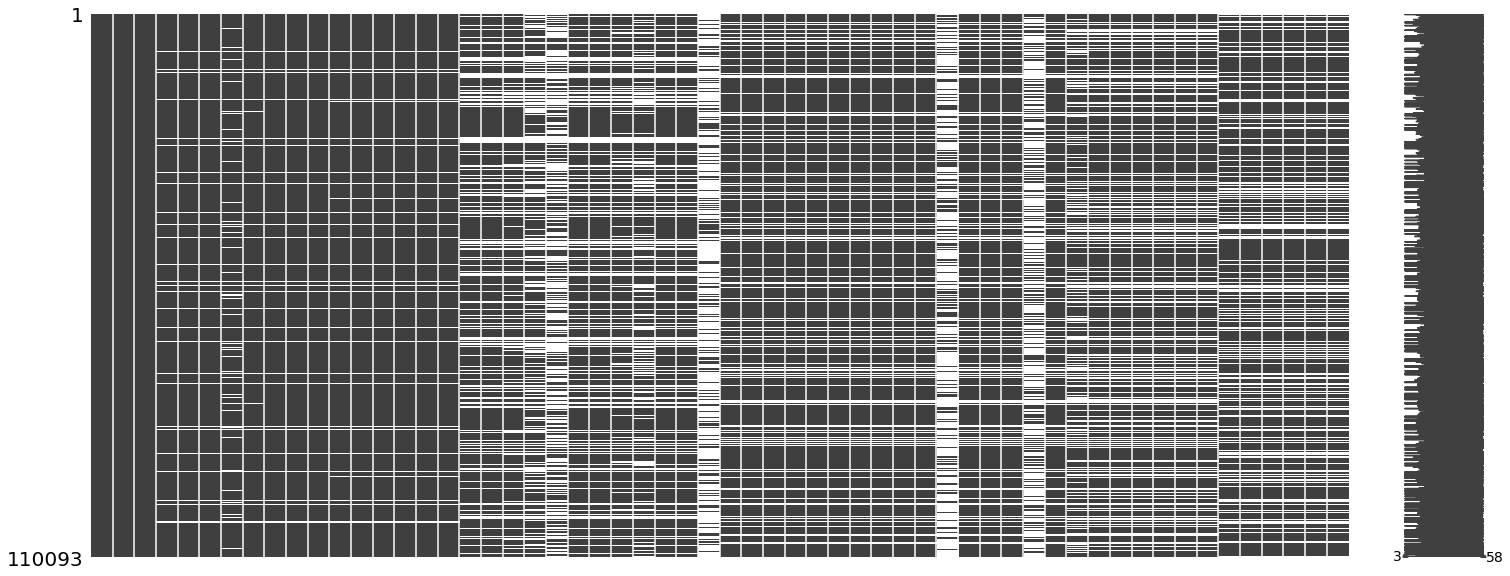

In [43]:
msno.matrix(df_train_merged)

In [44]:
df_train_merged.columns[df_train_merged.isnull().any()]

Index(['AMOUNT_ANNUITY_x', 'AMT_APPLICATION', 'AMOUNT_CREDIT_x',
       'AMOUNT_PAYMENT', 'AMOUNT_GOODS_PAYMENT', 'DAYS_DECISION',
       'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING',
       'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE',
       'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL', 'DAYS_CREDIT',
       'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT',
       'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE',
       'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY', 'GENDER', 'CHILDRENS',
       'TOTAL_SALARY', 'AMOUNT_CREDIT_y', 'AMOUNT_ANNUITY_y',
       'EDUCATION_LEVEL', 'FAMILY_STATUS', 'REGION_POPULATION', 'AGE',
       'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDI

In [45]:
df_test_merged.columns[df_test_merged.isnull().any()]


Index(['AMOUNT_ANNUITY_x', 'AMT_APPLICATION', 'AMOUNT_CREDIT_x',
       'AMOUNT_PAYMENT', 'AMOUNT_GOODS_PAYMENT', 'DAYS_DECISION',
       'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING',
       'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE',
       'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL', 'DAYS_CREDIT',
       'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT',
       'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE',
       'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY', 'GENDER', 'CHILDRENS',
       'TOTAL_SALARY', 'AMOUNT_CREDIT_y', 'AMOUNT_ANNUITY_y',
       'EDUCATION_LEVEL', 'FAMILY_STATUS', 'REGION_POPULATION', 'AGE',
       'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDI

In [46]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    print(f"Total NA-values = {na.sum()}")
    return result.T

In [47]:
check_missings(df_train_merged)

Total NA-values = 1352380


,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY_x,AMT_APPLICATION,AMOUNT_CREDIT_x,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
Total,0,0,0,5576,5437,5437,11691,5751,5437,5437,...,32613,32613,32613,32613,28126,28126,28126,28128,28126,28128
Percent,0,0,0,5.06481,4.93855,4.93855,10.6192,5.22377,4.93855,4.93855,...,29.6231,29.6231,29.6231,29.6231,25.5475,25.5475,25.5475,25.5493,25.5475,25.5493
Types,int64,int64,object,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [48]:
check_missings(df_test_merged)

Total NA-values = 2035914


,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY_x,AMT_APPLICATION,AMOUNT_CREDIT_x,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
Total,0,0,8270,8057,8057,17325,8540,8057,8057,8270,...,49104,49104,49104,49104,42568,42568,42568,42574,42568,42574
Percent,0,0,5.00784,4.87886,4.87886,10.491,5.17134,4.87886,4.87886,5.00784,...,29.7346,29.7346,29.7346,29.7346,25.7768,25.7768,25.7768,25.7804,25.7768,25.7804
Types,int64,object,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [49]:
df_train_merged["TARGET"].unique()


array([0, 1], dtype=int64)

In [50]:
df_train_merged["TARGET"].value_counts()


0    101196
1      8897
Name: TARGET, dtype: int64

Целевое значение очень мало представлено, всего 9% процентов от общего количества

Удалим признаки, где больше 50% процентов пропусков

In [51]:
treshold = len(df_train_merged)*0.5
df_train_merged = df_train_merged.dropna(axis = 1, thresh=treshold)
columns_train = df_train_merged.columns

In [52]:
df_train_merged

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY_x,AMT_APPLICATION,AMOUNT_CREDIT_x,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,123687442,0,Cash,7703.80500,68787.180000,67592.100000,4813.0800,68787.180,1221.000000,86.666667,...,1.0,0.0,0.0,2.0,1.000000,5.750000,2653.000000,2659.0,6275.9250,3960.37125
1,123597908,1,Cash,27919.00125,331908.750000,434949.750000,0.0000,331908.750,659.250000,38.750000,...,NaN,NaN,NaN,NaN,1.000000,9.000000,450.000000,457.0,11349.9000,11349.90000
2,123526683,0,Cash,32538.47625,353857.500000,402818.250000,18814.5000,707715.000,1423.166667,16.833333,...,0.0,7.0,0.0,4.0,0.500000,10.000000,1917.250000,1917.5,20169.4725,20169.47250
3,123710391,1,Cash,4237.69500,61206.750000,59661.000000,2250.0000,61206.750,1151.500000,2058.500000,...,0.0,0.0,0.0,0.0,1.000000,2.000000,1843.000000,1854.0,2450.1150,2450.11500
4,123590329,1,Cash,14583.62250,266842.000000,308073.500000,1462.5000,300197.250,741.000000,55.777778,...,NaN,NaN,NaN,NaN,1.000000,3.750000,1218.500000,1233.5,10608.3900,10608.39000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,123458312,0,Cash,13051.19700,66922.866000,74327.400000,0.8325,66922.866,1308.200000,1126.600000,...,NaN,NaN,NaN,NaN,1.000000,6.000000,2296.000000,2309.0,4725.6300,4725.63000
110089,123672463,0,Cash,9349.53300,68150.526923,67411.384615,6643.6500,88595.685,584.846154,26.692308,...,0.0,0.0,0.0,2.0,0.833333,5.833333,795.166667,789.5,6097.0125,6373.66500
110090,123723001,0,Cash,4000.29750,30363.750000,28244.250000,4281.7500,30363.750,464.500000,156.000000,...,NaN,NaN,NaN,NaN,1.000000,4.000000,70.000000,83.0,4998.6450,4998.64500
110091,123554358,0,Cash,24760.71000,299340.000000,327861.000000,0.0000,299340.000,789.000000,66.000000,...,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
for column in df_test_merged:
    if column not in columns_train:
        df_test_merged = df_test_merged.drop([column], axis=1)

In [54]:
df_test_merged

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY_x,AMT_APPLICATION,AMOUNT_CREDIT_x,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,123724268,Cash,16837.80750,143007.750000,143007.750,0.000,286015.500000,514.500000,36.750000,6.000000,...,0.0,0.0,1.0,4.0,1.00,7.500000,494.00,504.000000,11175.6150,11175.6150
1,123456549,Cash,26243.73000,321183.585000,393309.000,1.170,321183.585000,729.500000,67.000000,24.000000,...,1.0,0.0,0.0,2.0,2.50,53.500000,481.00,474.000000,24610.3875,24610.3875
2,123428178,Credit Card,32940.50625,386057.250000,438194.250,3304.125,386057.250000,1078.250000,214.625000,15.500000,...,0.0,0.0,1.0,6.0,1.00,16.000000,556.00,555.000000,49626.0000,49626.0000
3,123619984,Cash,13925.38500,397755.000000,357979.500,39775.500,397755.000000,637.000000,25.000000,36.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,123671104,Cash,7451.52000,50146.956000,45373.428,7230.285,62683.695000,1294.400000,1176.600000,9.333333,...,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165136,123487967,Cash,13829.87250,82500.000000,98340.000,NaN,247500.000000,219.666667,-1.000000,24.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165137,123536402,Cash,18183.60000,181498.500000,163347.750,18150.750,181498.500000,269.000000,65.000000,10.000000,...,0.0,0.0,0.0,0.0,1.00,8.000000,163.00,171.000000,24291.7200,24291.7200
165138,123718238,Cash,19887.28650,231750.000000,260080.650,0.000,257500.000000,1834.900000,-0.700000,16.800000,...,NaN,NaN,NaN,NaN,0.45,40.300000,1465.65,1477.450000,22731.7365,21749.1480
165139,123631557,Cash,20090.88000,260456.785714,303534.000,2322.000,260456.785714,1149.428571,18.571429,23.142857,...,NaN,NaN,NaN,NaN,1.00,11.900000,687.00,693.800000,20494.7730,18511.4610


In [55]:
df_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110093 entries, 0 to 110092
Data columns (total 54 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          110093 non-null  int64  
 1   TARGET                      110093 non-null  int64  
 2   NAME_CONTRACT_TYPE          110093 non-null  object 
 3   AMOUNT_ANNUITY_x            104517 non-null  float64
 4   AMT_APPLICATION             104656 non-null  float64
 5   AMOUNT_CREDIT_x             104656 non-null  float64
 6   AMOUNT_PAYMENT              98402 non-null   float64
 7   AMOUNT_GOODS_PAYMENT        104342 non-null  float64
 8   DAYS_DECISION               104656 non-null  float64
 9   SELLERPLACE_AREA            104656 non-null  float64
 10  CNT_PAYMENT                 104518 non-null  float64
 11  DAYS_FIRST_DRAWING          104176 non-null  float64
 12  DAYS_FIRST_DUE              104176 non-null  float64
 13  DAYS_LAST_DUE_

In [56]:
df_test_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165141 entries, 0 to 165140
Data columns (total 53 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          165141 non-null  int64  
 1   NAME_CONTRACT_TYPE          165141 non-null  object 
 2   AMOUNT_ANNUITY_x            156871 non-null  float64
 3   AMT_APPLICATION             157084 non-null  float64
 4   AMOUNT_CREDIT_x             157084 non-null  float64
 5   AMOUNT_PAYMENT              147816 non-null  float64
 6   AMOUNT_GOODS_PAYMENT        156601 non-null  float64
 7   DAYS_DECISION               157084 non-null  float64
 8   SELLERPLACE_AREA            157084 non-null  float64
 9   CNT_PAYMENT                 156871 non-null  float64
 10  DAYS_FIRST_DRAWING          156403 non-null  float64
 11  DAYS_FIRST_DUE              156403 non-null  float64
 12  DAYS_LAST_DUE_1ST_VERSION   156403 non-null  float64
 13  DAYS_LAST_DUE 

Text(0, 0.5, 'count')

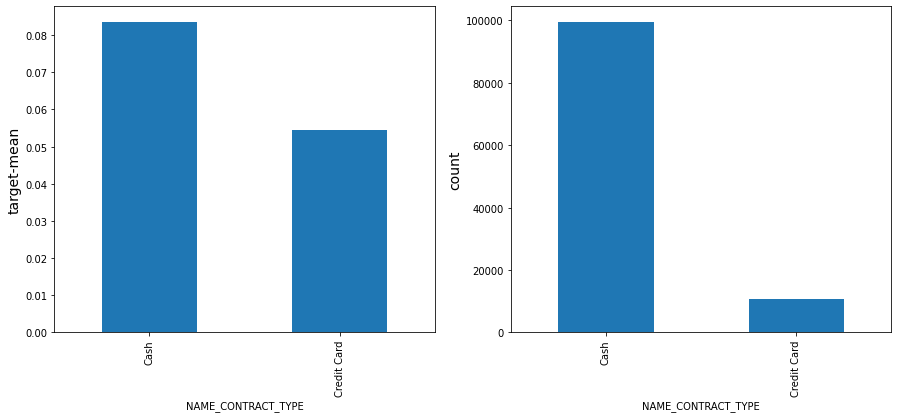

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df_train_merged.groupby(["NAME_CONTRACT_TYPE"])["TARGET"].mean().plot(kind="bar", ax=axes[0])
df_train_merged.groupby(["NAME_CONTRACT_TYPE"])["TARGET"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)

видим, что тип кредита cradit card имеет большую значимость, т.к. при меньшем количестве в среднем не сильно уступает наличным.

Text(0, 0.5, 'count')

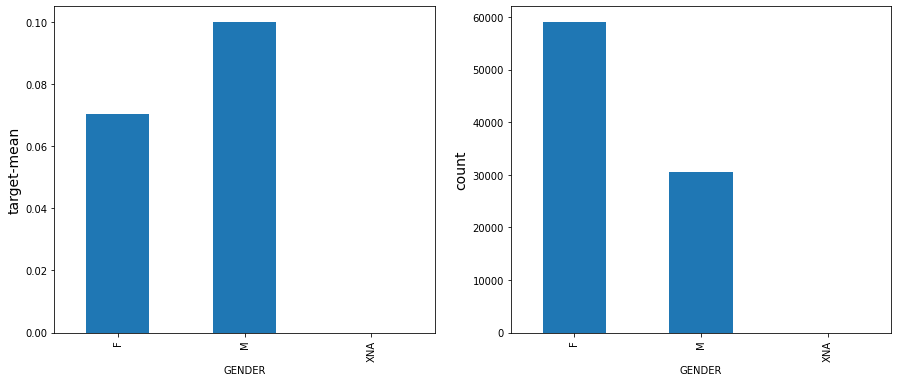

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df_train_merged.groupby(["GENDER"])["TARGET"].mean().plot(kind="bar", ax=axes[0])
df_train_merged.groupby(["GENDER"])["TARGET"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)

In [59]:
#в данных по полу есть третья графа, пустая. используем ее для пропусков
df_train_merged['GENDER'].fillna('XNA', inplace=True)


Text(0, 0.5, 'count')

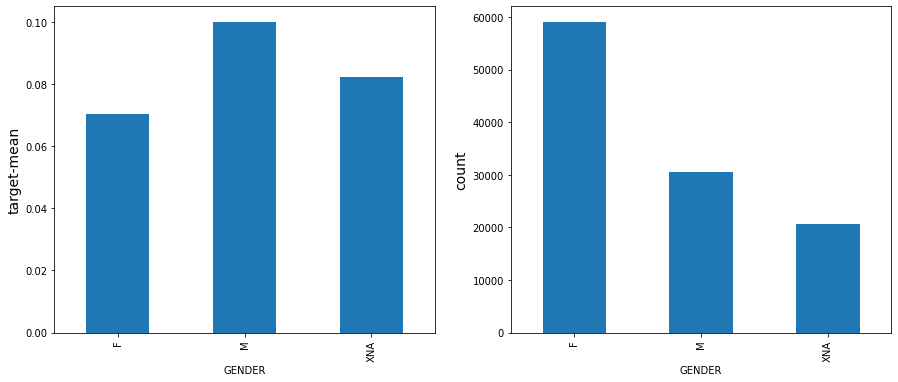

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df_train_merged.groupby(["GENDER"])["TARGET"].mean().plot(kind="bar", ax=axes[0])
df_train_merged.groupby(["GENDER"])["TARGET"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)

мужчин меньше, но они сильнее связаны с целевой переменной. При этом, мы видим, что количество пропусков также сильно связано с целевой переменной. Это означает, что либо это мужчины, либо в пропуски попали все связанные с целевым значением женщины

Text(0, 0.5, 'count')

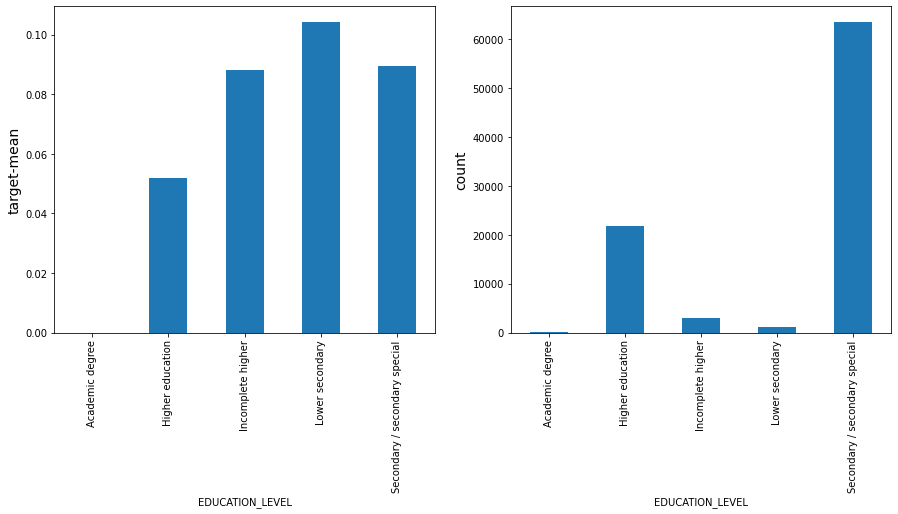

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df_train_merged.groupby(["EDUCATION_LEVEL"])["TARGET"].mean().plot(kind="bar", ax=axes[0])
df_train_merged.groupby(["EDUCATION_LEVEL"])["TARGET"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)


lower secondary и incomplete higher сильно выбиваются.

Text(0, 0.5, 'count')

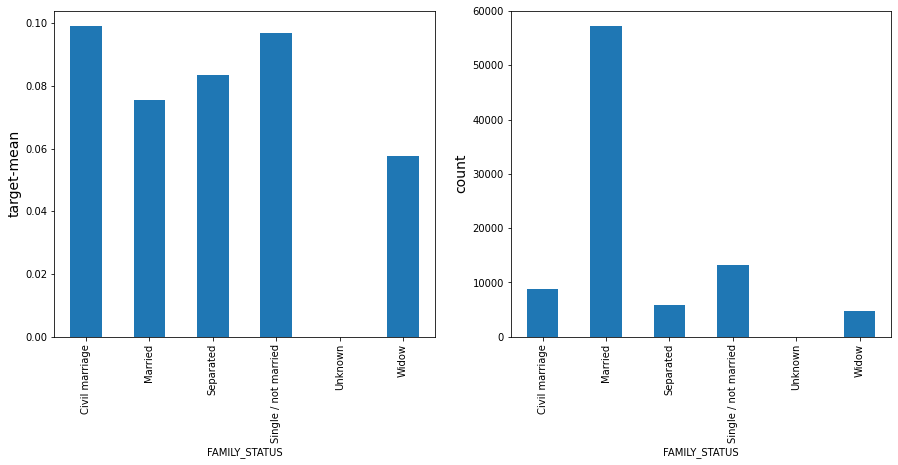

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df_train_merged.groupby(["FAMILY_STATUS"])["TARGET"].mean().plot(kind="bar", ax=axes[0])
df_train_merged.groupby(["FAMILY_STATUS"])["TARGET"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)


In [63]:
class MissingImputer():
    """Заполнение пропусков"""
    
    def __init__(self):
        self.medians=None
        self.mins = None

    def fit(self, df):
        self.medians = df.median()
    
    def transform(self, df):
        #Обработка количественных признаков 
        df['FAMILY_STATUS'].fillna('Unknown', inplace=True)
        
        numerical_features = df.select_dtypes(include=[np.number])
        
        cat_features = df.select_dtypes(include = ['object'])

        for num in numerical_features:
            numerical_features.loc[(numerical_features[num].isnull(), [num])] = numerical_features[num].median()

        for cat in cat_features:
            cat_features.loc[(cat_features[cat].isnull(), [cat])] = df[cat].mode()[0]
                        
        #Генерация новых признаков
        df['Credit_card_man_XNA'] = 0
        df.loc[(df['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df['GENDER'] != 'F'), 'Credit_card_man_XNA'] = 1
                
        df['Credit_card_education'] = 0
        df.loc[(df['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df['EDUCATION_LEVEL'] == 'Lower secondary'), 'Credit_card_education'] = 1
        df.loc[(df['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df['EDUCATION_LEVEL'] == 'Incomplete higher'), 'Credit_card_education'] = 1
                
        df['Credit_card_marital'] = 1
        df.loc[(df['NAME_CONTRACT_TYPE'] == 'Cash') | (df['FAMILY_STATUS'] == 'Married'), 'Credit_card_marital'] = 0

        for cat in cat_features:
            #enc = LabelEncoder()
            #cat_features[cat] = enc.fit_transform(cat_features[cat])
            cat_features = pd.concat([cat_features, pd.get_dummies(cat_features[cat], prefix=cat)], axis=1)
            
        #cat_features = cat_features.drop(['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], axis=1)
        df = pd.concat([numerical_features, cat_features], axis=1)
        
        return df

In [64]:
imputer = MissingImputer()

imputer.fit(df_train_merged)

df_train_merged = imputer.transform(df_train_merged)
df_test_merged = imputer.transform(df_test_merged)

In [66]:
df_train_merged['Credit_card_man_XNA'] = 0
df_train_merged.loc[(df_train_merged['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df_train_merged['GENDER'] != 'F'), 'Credit_card_man_XNA'] = 1
                
df_train_merged['Credit_card_education'] = 0
df_train_merged.loc[(df_train_merged['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df_train_merged['EDUCATION_LEVEL'] == 'Lower secondary'), 'Credit_card_education'] = 1
df_train_merged.loc[(df_train_merged['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df_train_merged['EDUCATION_LEVEL'] == 'Incomplete higher'), 'Credit_card_education'] = 1
                
df_train_merged['Credit_card_marital'] = 1
df_train_merged.loc[(df_train_merged['NAME_CONTRACT_TYPE'] == 'Cash') | (df_train_merged['FAMILY_STATUS'] == 'Married'), 'Credit_card_marital'] = 0

In [68]:
df_test_merged['Credit_card_man_XNA'] = 0
df_test_merged.loc[(df_test_merged['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df_test_merged['GENDER'] != 'F'), 'Credit_card_man_XNA'] = 1
                
df_test_merged['Credit_card_education'] = 0
df_test_merged.loc[(df_test_merged['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df_test_merged['EDUCATION_LEVEL'] == 'Lower secondary'), 'Credit_card_education'] = 1
df_test_merged.loc[(df_test_merged['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df_test_merged['EDUCATION_LEVEL'] == 'Incomplete higher'), 'Credit_card_education'] = 1
                
df_test_merged['Credit_card_marital'] = 1
df_test_merged.loc[(df_test_merged['NAME_CONTRACT_TYPE'] == 'Cash') | (df_test_merged['FAMILY_STATUS'] == 'Married'), 'Credit_card_marital'] = 0

In [69]:
df_train_merged = df_train_merged.drop(['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], axis=1)
df_test_merged = df_test_merged.drop(['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], axis=1)

In [70]:
def plot_features_distribution(train: pd.DataFrame, test: pd.DataFrame, features):
    """
    Построение графика распределения признака на обучающем и тестовом наборе данных.

    Parameters
    ----------
    train: pandas.core.frame.DataFrame
        Обучающая выборка.

    test: pandas.core.frame.DataFrame
        Тестовая выборка.

    features: List[str]
        Список с названеим признаков.

    """
    n_rows, n_cols = len(features)//5, 5
    if len(features) % 5:
        n_rows += 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10*n_rows, 10*n_cols))
    for num, feature in enumerate(features, start=1):
        plt.subplot(n_rows, n_cols, num)
        statistic, pvalue = ks_2samp(train[feature].sample(5000), test[feature].sample(5000))
        plt.title(f"{feature}, p-value = {round(pvalue, 4)}", size=14)
        sns.distplot(train[feature], hist=False, color="#33137d")
        sns.distplot(test[feature], color="#007539", hist=False)


In [71]:
numerical_features = df_train_merged.select_dtypes(include=[np.number])
numerical_features.columns

Index(['APPLICATION_NUMBER', 'TARGET', 'AMOUNT_ANNUITY_x', 'AMT_APPLICATION',
       'AMOUNT_CREDIT_x', 'AMOUNT_PAYMENT', 'AMOUNT_GOODS_PAYMENT',
       'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE',
       'DAYS_CREDIT_UPDATE', 'CHILDRENS', 'TOTAL_SALARY', 'AMOUNT_CREDIT_y',
       'AMOUNT_ANNUITY_y', 'REGION_POPULATION', 'AGE', 'DAYS_ON_LAST_JOB',
       'FLAG_PHONE', 'FLAG_EMAIL', 'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
   

In [72]:
features = ['AMOUNT_ANNUITY_x', 'AMT_APPLICATION',
       'AMOUNT_CREDIT_x', 'AMOUNT_PAYMENT', 'AMOUNT_GOODS_PAYMENT',
       'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE',
       'DAYS_CREDIT_UPDATE', 'CHILDRENS', 'TOTAL_SALARY', 'AMOUNT_CREDIT_y',
       'AMOUNT_ANNUITY_y', 'REGION_POPULATION', 'AGE', 'DAYS_ON_LAST_JOB',
       'FLAG_PHONE', 'FLAG_EMAIL', 'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT', 'NAME_CONTRACT_TYPE_Cash',
       'NAME_CONTRACT_TYPE_Credit Card', 'GENDER_F', 'GENDER_M', 'GENDER_XNA',
       'EDUCATION_LEVEL_Academic degree', 'EDUCATION_LEVEL_Higher education',
       'EDUCATION_LEVEL_Incomplete higher', 'EDUCATION_LEVEL_Lower secondary',
       'EDUCATION_LEVEL_Secondary / secondary special',
       'FAMILY_STATUS_Civil marriage', 'FAMILY_STATUS_Married',
       'FAMILY_STATUS_Separated', 'FAMILY_STATUS_Single / not married',
       'FAMILY_STATUS_Unknown', 'FAMILY_STATUS_Widow']

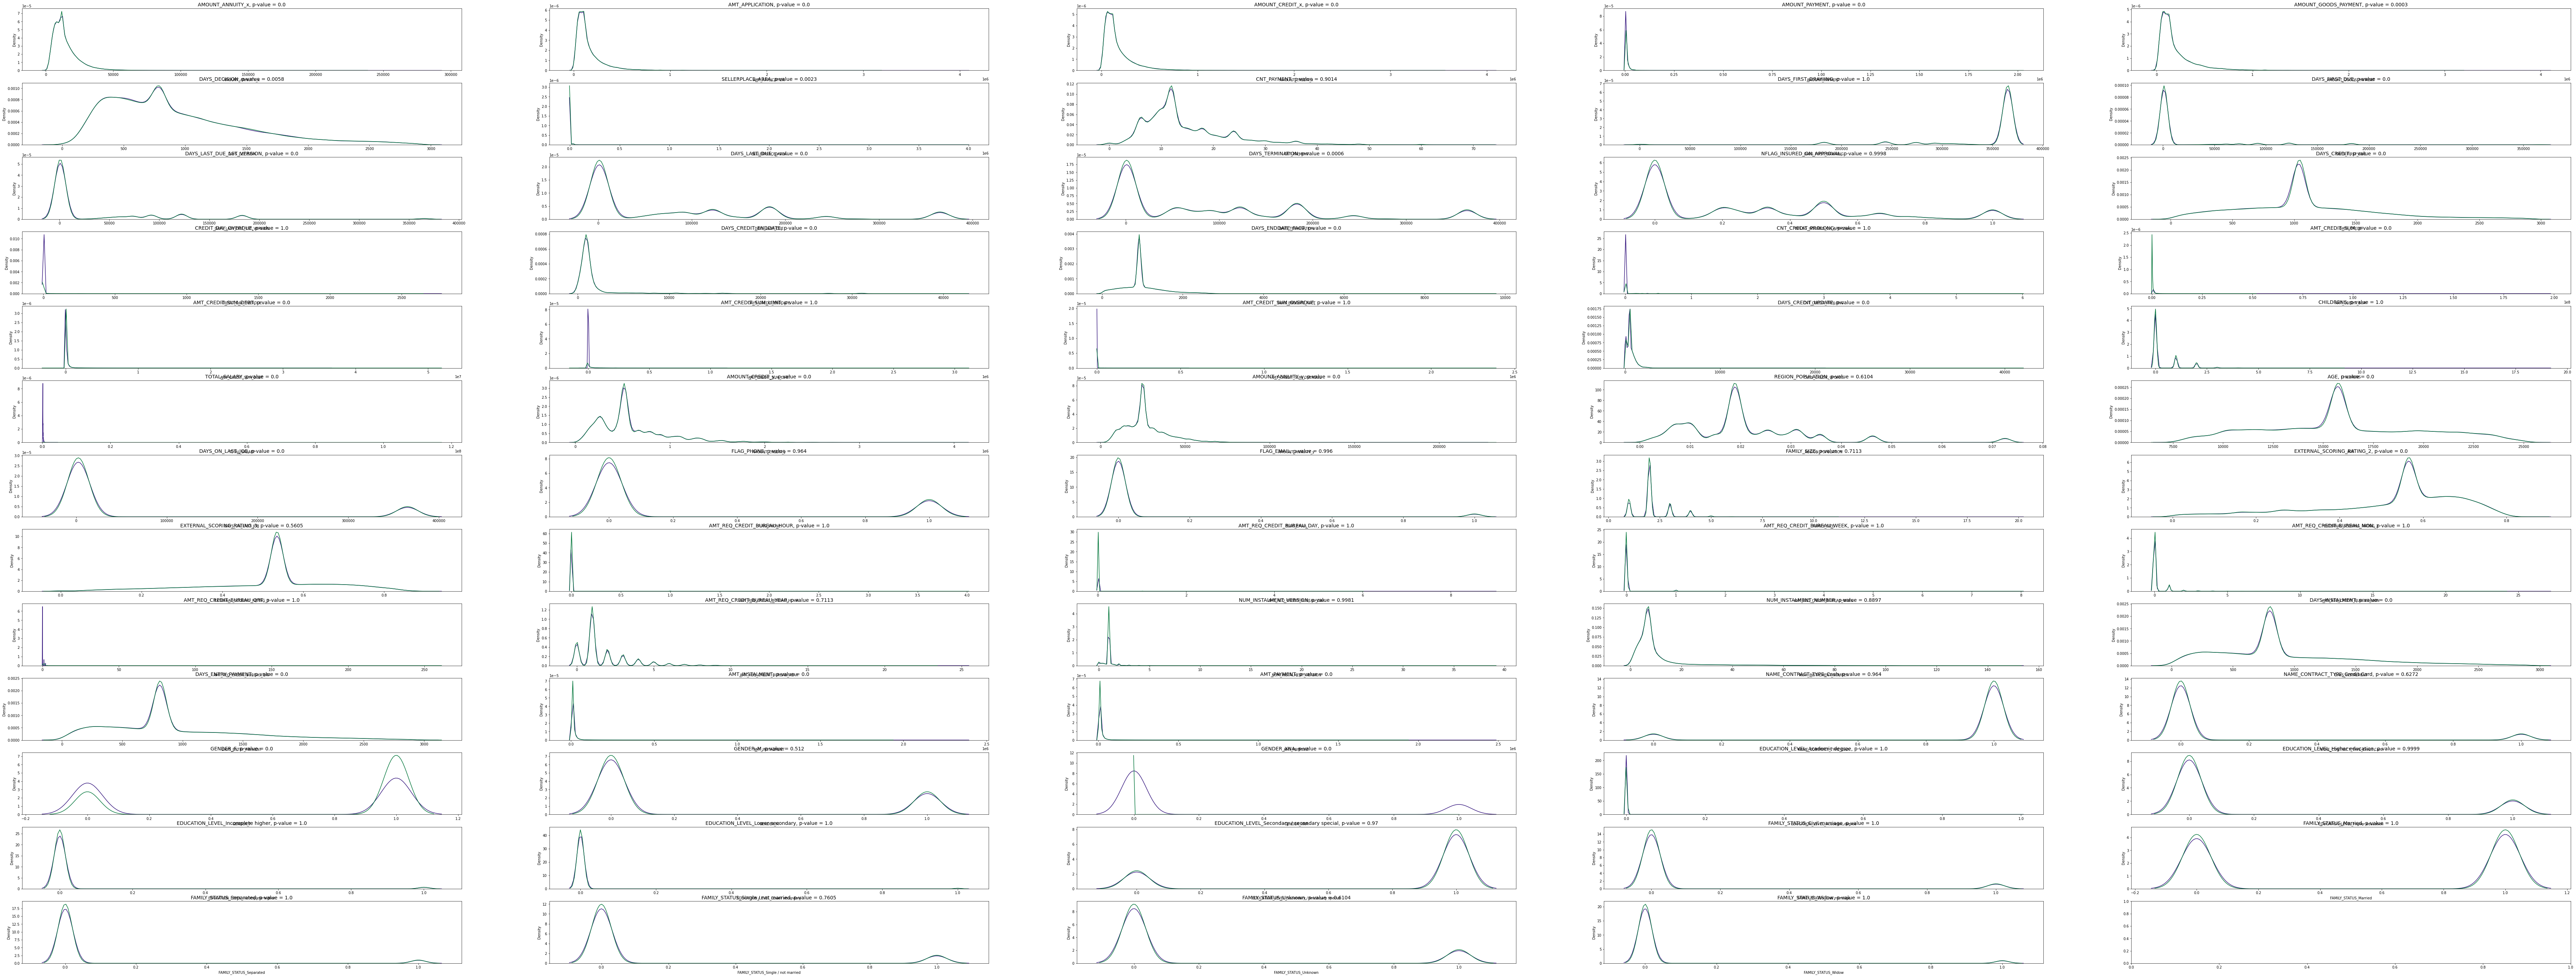

In [73]:
plot_features_distribution(df_train_merged, df_test_merged, features=features)

In [74]:
df_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110093 entries, 0 to 110092
Data columns (total 69 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   APPLICATION_NUMBER                             110093 non-null  int64  
 1   TARGET                                         110093 non-null  int64  
 2   AMOUNT_ANNUITY_x                               110093 non-null  float64
 3   AMT_APPLICATION                                110093 non-null  float64
 4   AMOUNT_CREDIT_x                                110093 non-null  float64
 5   AMOUNT_PAYMENT                                 110093 non-null  float64
 6   AMOUNT_GOODS_PAYMENT                           110093 non-null  float64
 7   DAYS_DECISION                                  110093 non-null  float64
 8   SELLERPLACE_AREA                               110093 non-null  float64
 9   CNT_PAYMENT                          

В целом, за исключением ряда небольших отклонений, распределения в тестовой и обучающей выборке совпадают. 

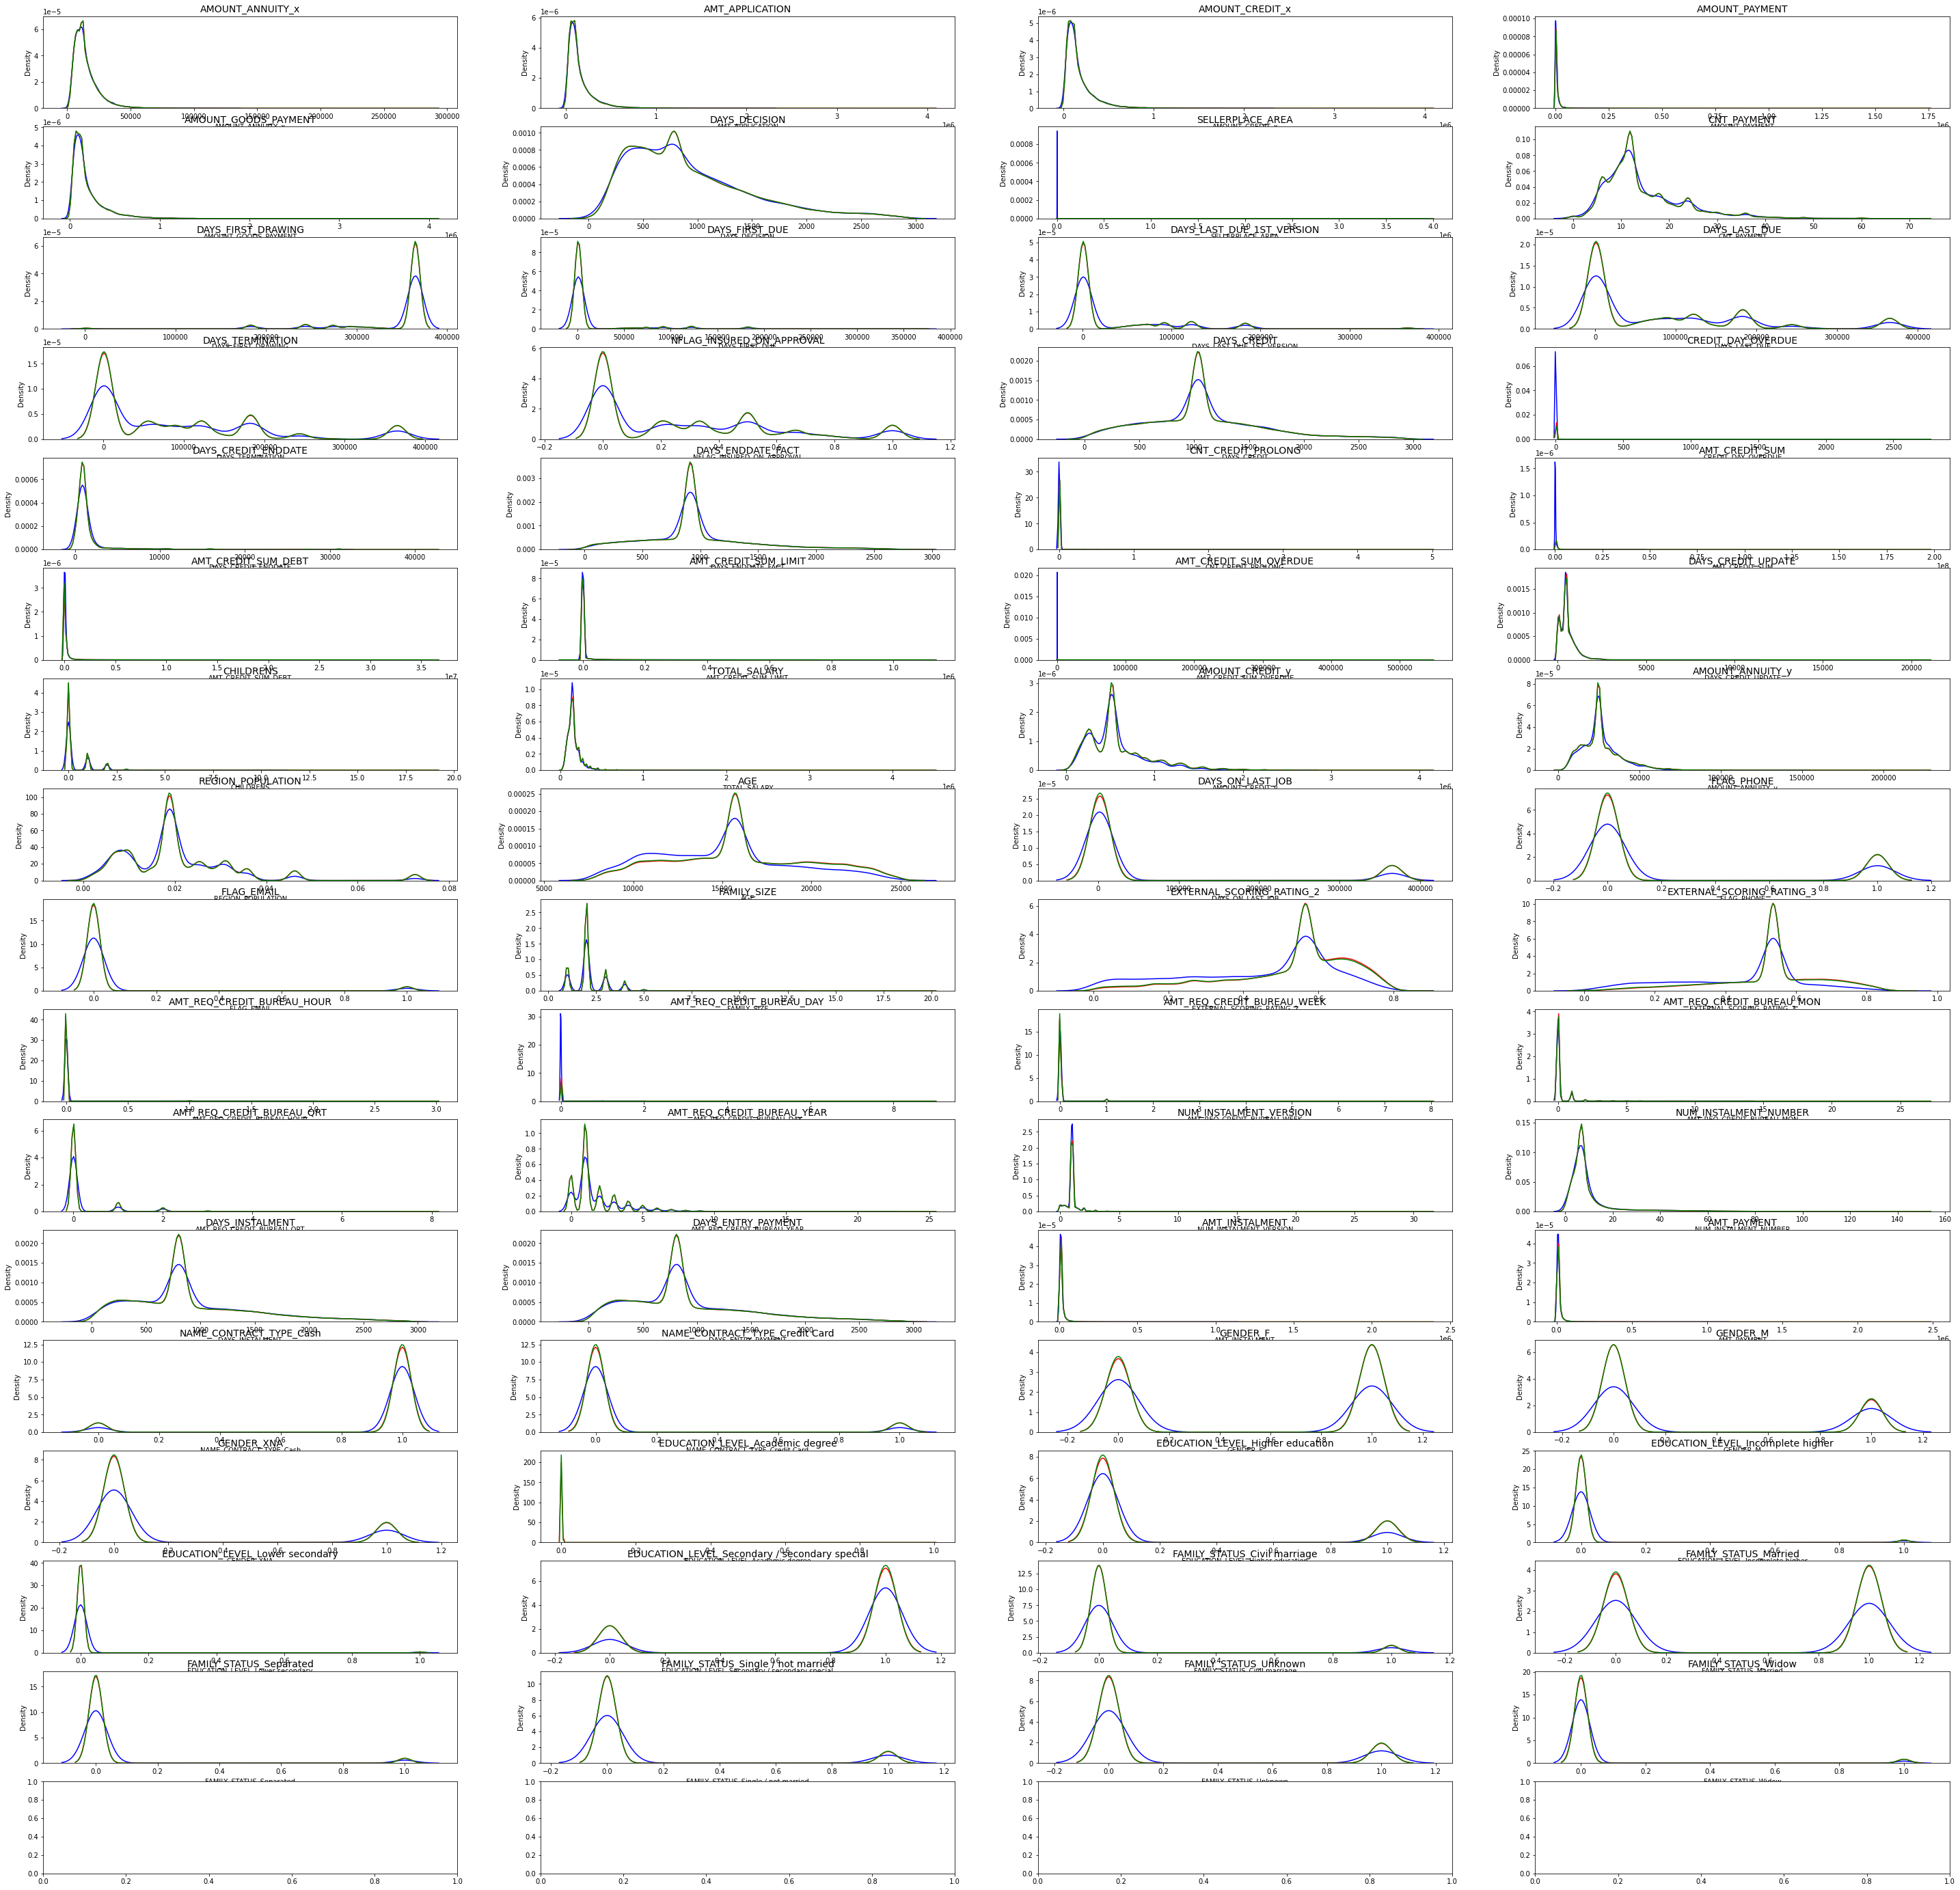

In [75]:
fig, axes = plt.subplots(17, 4, figsize=(50, 50))

for num, feature in enumerate(features):
    sns.kdeplot(df_train_merged.loc[df_train_merged['TARGET']==1, feature], ax=axes[num//4, num%4], color="blue", label="target=1")
    sns.kdeplot(df_train_merged.loc[df_train_merged['TARGET']==0, feature], ax=axes[num//4, num%4], color="red", label="target=0")
    sns.kdeplot(df_train_merged[feature], ax=axes[num//4, num%4], color="green", label="train")
    axes[num//4, num%4].set_title(feature, fontsize=14)
plt.show()

In [76]:
target = df_train_merged["TARGET"]
target

0         0
1         1
2         0
3         1
4         1
         ..
110088    0
110089    0
110090    0
110091    0
110092    0
Name: TARGET, Length: 110093, dtype: int64

In [77]:
correlation = df_train_merged.corr()
corr_with_target = correlation["TARGET"].sort_values(ascending = False)
corr_with_target

TARGET                                           1.000000
EDUCATION_LEVEL_Secondary / secondary special    0.045948
GENDER_M                                         0.043532
Credit_card_man_XNA                              0.031425
NAME_CONTRACT_TYPE_Cash                          0.031365
                                                   ...   
DAYS_ON_LAST_JOB                                -0.044777
EDUCATION_LEVEL_Higher education                -0.052760
AGE                                             -0.073696
EXTERNAL_SCORING_RATING_3                       -0.140773
EXTERNAL_SCORING_RATING_2                       -0.142389
Name: TARGET, Length: 69, dtype: float64

Прямой корелляции с таргетом нет ни у одного показателя, но есть достаточно значительные обратные - рейтинги заемщика EXTERNAL_SCORING_RATING.

In [78]:
parameters = {
    "max_depth": [6, 8, 10, 15],
    "min_samples_leaf": [15, 25, 50, 100, 250]
}

model = RandomForestClassifier(
    n_estimators=100, n_jobs=6, random_state=27
)
grid = GridSearchCV(
    model,
    parameters,
    n_jobs=-1,
    verbose=2,
    scoring=make_scorer(roc_auc_score),
    cv=3,
)

In [79]:
numerical_features = df_train_merged.select_dtypes(include=[np.number])

In [80]:
%%time
grid.fit(
    numerical_features.drop(["TARGET"], axis=1),
    df_train_merged["TARGET"]
)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.9min finished


Wall time: 4min 1s


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=6, random_state=27),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10, 15],
                         'min_samples_leaf': [15, 25, 50, 100, 250]},
             scoring=make_scorer(roc_auc_score), verbose=2)

Text(0.5, 1.0, 'What are the top important features to start with?')

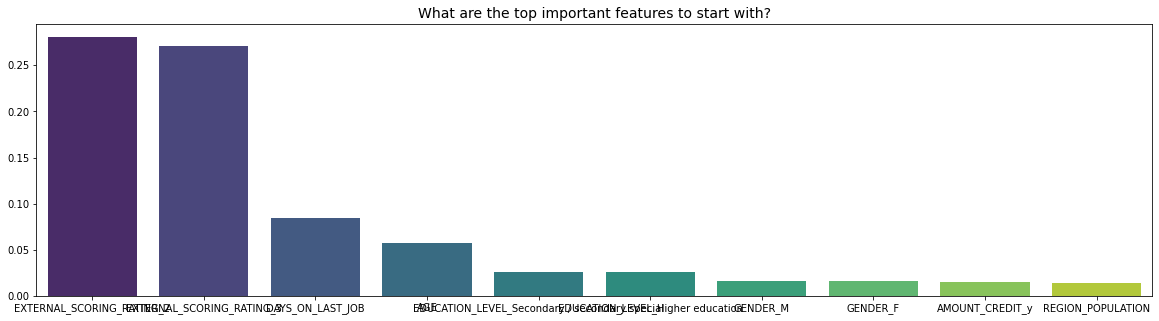

In [81]:
ntop = 10
importances = grid.best_estimator_.feature_importances_
idx = np.argsort(importances)[::-1][0:ntop]
feature_names = numerical_features.drop(["TARGET"], axis=1).columns.values

plt.figure(figsize=(20,5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


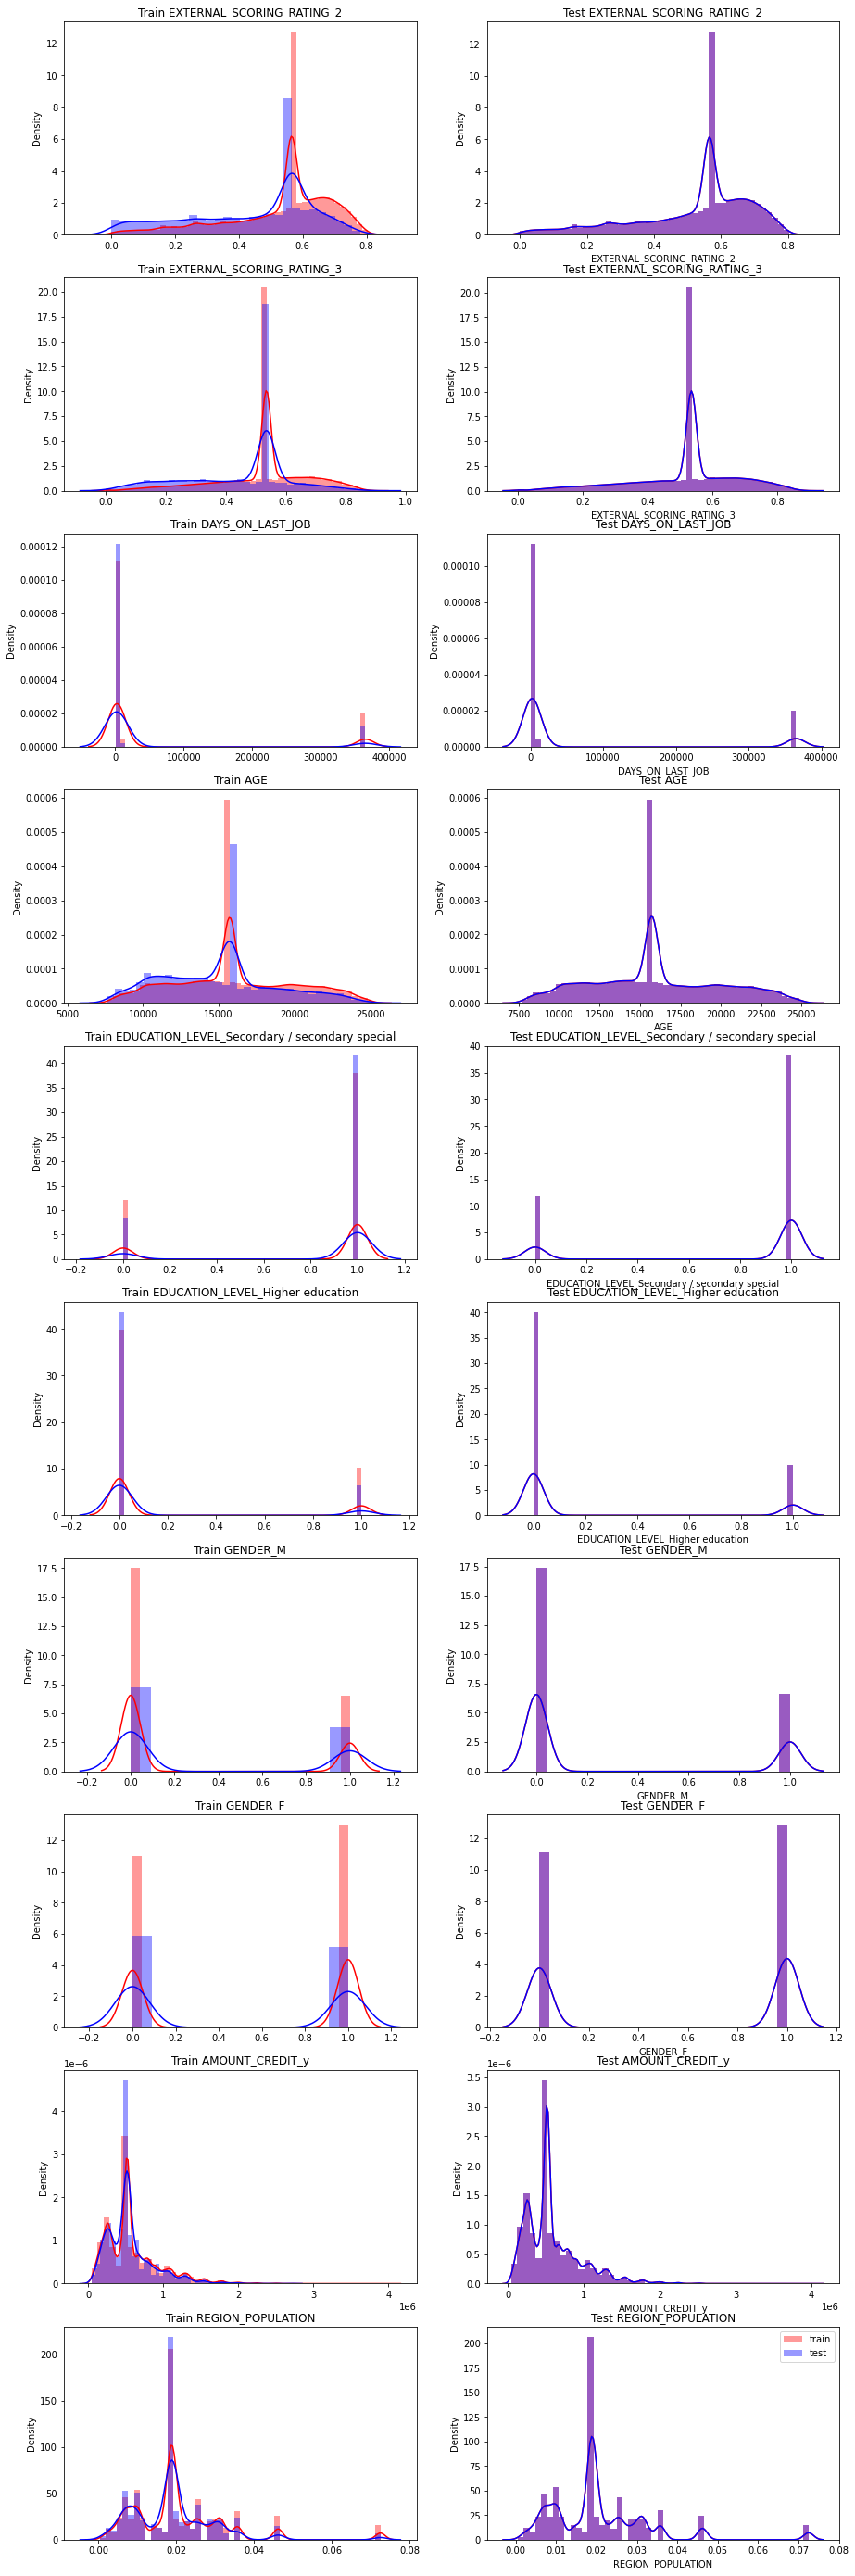

In [82]:
fig, axes = plt.subplots(ntop, 2, figsize=(15, 5*ntop))

for n in range(ntop):
    sns.distplot(
        numerical_features.loc[df_train_merged["TARGET"]==0, feature_names[idx][n]],
        ax=axes[n, 0],
        color="red",
        label="target=0",
        norm_hist=True,
    )
    sns.distplot(
        numerical_features.loc[df_train_merged["TARGET"]==1, feature_names[idx][n]],
        ax=axes[n, 0],
        color="blue",
        label="target=1",
        norm_hist=True
    )
    sns.distplot(
        numerical_features.loc[:, feature_names[idx][n]],
        ax=axes[n, 1],
        color="red", 
        norm_hist=True,
        label="train"
    )
    sns.distplot(
        numerical_features.loc[:, feature_names[idx][n]],
        ax=axes[n, 1],
        color="blue",
        norm_hist=True,
        label="test"
    )

    axes[n, 0].set_title("Train {}".format(feature_names[idx][n]))
    axes[n, 1].set_title("Test {}".format(feature_names[idx][n]))
    axes[n, 0].set_xlabel("")
    plt.legend(loc="best")

In [83]:
X = df_train_merged.drop(["TARGET"], axis=1)
X = X.set_index('APPLICATION_NUMBER')
ind = df_train_merged["APPLICATION_NUMBER"]
y = df_train_merged["TARGET"]
y = pd.concat([ind, y], axis=1)
y = y.set_index('APPLICATION_NUMBER')

In [84]:
y

,TARGET
APPLICATION_NUMBER,
123687442,0
123597908,1
123526683,0
123710391,1
123590329,1
...,...
123458312,0
123672463,0
123723001,0


In [85]:
x_train, x_valid = train_test_split(
    X, train_size=0.6, random_state=27, shuffle=True
)
y_train, y_valid = train_test_split(
    y, train_size=0.6, random_state=27, shuffle=True
)

x_valid, x_test = train_test_split(
    x_valid, train_size=0.5, random_state=72, shuffle=True
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.5, random_state=72, shuffle=True
)

In [86]:
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))
#print("x_public_lb.shape = {} rows, {} cols".format(*x_public_lb.shape))

x_train.shape = 66055 rows, 67 cols
x_valid.shape = 22019 rows, 67 cols
x_test.shape = 22019 rows, 67 cols


In [87]:
y_train

,TARGET
APPLICATION_NUMBER,
123628434,0
123632049,0
123548395,0
123626067,0
123499208,0
...,...
123478828,0
123595728,0
123692353,0


In [88]:
model = xgb.XGBClassifier(random_state=42, learning_rate=0.1, n_estimators=100)
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [89]:
y_train

,TARGET
APPLICATION_NUMBER,
123628434,0
123632049,0
123548395,0
123626067,0
123499208,0
...,...
123478828,0
123595728,0
123692353,0


In [90]:
train_score = roc_auc_score(y_train, model.predict(x_train))
valid_score = roc_auc_score(y_valid, model.predict(x_valid))
test_score = roc_auc_score(y_test, model.predict(x_test))


print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.523, Valid-score: 0.505, Test-score: 0.503


In [91]:
y_train

,TARGET
APPLICATION_NUMBER,
123628434,0
123632049,0
123548395,0
123626067,0
123499208,0
...,...
123478828,0
123595728,0
123692353,0


In [92]:
def evaluate_model(model, *args):
    """
    Оценка качества модели.

    Parameters
    ----------
    model: catboost.core.CatBoostClassifier
        Экземпляр обученного классификатора.

    args: pandas.core.frame.DataFrame
        Пары из обучающей выборки и вектора истинных ответов.
        Опциональные параметры.

    """
    eval_data = [(args[i], args[i+1]) for i in range(0, len(args), 2)]
    if eval_data:
        for sample, target in eval_data:
            y_pred = model.predict_proba(sample)[:, 1]
            score = roc_auc_score(target, y_pred)
            print(f"score = {round(score, 6)}")

In [93]:
evaluate_model(model, x_train, y_train, x_valid, y_valid)

score = 0.838909
score = 0.706544


In [94]:
df_test_merged['APPLICATION_NUMBER'] = df_test_merged.index
df_test_merged = df_test_merged.reset_index(drop=True)


In [95]:
df_test_merged

,APPLICATION_NUMBER,AMOUNT_ANNUITY_x,AMT_APPLICATION,AMOUNT_CREDIT_x,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,...,EDUCATION_LEVEL_Secondary / secondary special,FAMILY_STATUS_Civil marriage,FAMILY_STATUS_Married,FAMILY_STATUS_Separated,FAMILY_STATUS_Single / not married,FAMILY_STATUS_Unknown,FAMILY_STATUS_Widow,Credit_card_man_XNA,Credit_card_education,Credit_card_marital
0,0,16837.80750,143007.750000,143007.750,0.000,286015.500000,514.500000,36.750000,6.000000,365243.0,...,1,0,1,0,0,0,0,1,0,0
1,1,26243.73000,321183.585000,393309.000,1.170,321183.585000,729.500000,67.000000,24.000000,365243.0,...,1,0,1,0,0,0,0,0,0,0
2,2,32940.50625,386057.250000,438194.250,3304.125,386057.250000,1078.250000,214.625000,15.500000,365243.0,...,1,0,1,0,0,0,0,1,1,0
3,3,13925.38500,397755.000000,357979.500,39775.500,397755.000000,637.000000,25.000000,36.000000,365243.0,...,1,0,0,0,0,1,0,0,0,0
4,4,7451.52000,50146.956000,45373.428,7230.285,62683.695000,1294.400000,1176.600000,9.333333,365243.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165136,165136,13829.87250,82500.000000,98340.000,3363.975,247500.000000,219.666667,-1.000000,24.000000,182760.0,...,1,0,0,0,0,1,0,0,0,0
165137,165137,18183.60000,181498.500000,163347.750,18150.750,181498.500000,269.000000,65.000000,10.000000,365243.0,...,1,0,0,0,1,0,0,1,0,0
165138,165138,19887.28650,231750.000000,260080.650,0.000,257500.000000,1834.900000,-0.700000,16.800000,292738.0,...,1,0,0,0,0,1,0,0,0,0
165139,165139,20090.88000,260456.785714,303534.000,2322.000,260456.785714,1149.428571,18.571429,23.142857,365243.0,...,1,0,1,0,0,0,0,0,0,0


In [96]:
df_test_merged_res = df_test_merged.copy()

In [97]:
df_test_merged_res

,APPLICATION_NUMBER,AMOUNT_ANNUITY_x,AMT_APPLICATION,AMOUNT_CREDIT_x,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,...,EDUCATION_LEVEL_Secondary / secondary special,FAMILY_STATUS_Civil marriage,FAMILY_STATUS_Married,FAMILY_STATUS_Separated,FAMILY_STATUS_Single / not married,FAMILY_STATUS_Unknown,FAMILY_STATUS_Widow,Credit_card_man_XNA,Credit_card_education,Credit_card_marital
0,0,16837.80750,143007.750000,143007.750,0.000,286015.500000,514.500000,36.750000,6.000000,365243.0,...,1,0,1,0,0,0,0,1,0,0
1,1,26243.73000,321183.585000,393309.000,1.170,321183.585000,729.500000,67.000000,24.000000,365243.0,...,1,0,1,0,0,0,0,0,0,0
2,2,32940.50625,386057.250000,438194.250,3304.125,386057.250000,1078.250000,214.625000,15.500000,365243.0,...,1,0,1,0,0,0,0,1,1,0
3,3,13925.38500,397755.000000,357979.500,39775.500,397755.000000,637.000000,25.000000,36.000000,365243.0,...,1,0,0,0,0,1,0,0,0,0
4,4,7451.52000,50146.956000,45373.428,7230.285,62683.695000,1294.400000,1176.600000,9.333333,365243.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165136,165136,13829.87250,82500.000000,98340.000,3363.975,247500.000000,219.666667,-1.000000,24.000000,182760.0,...,1,0,0,0,0,1,0,0,0,0
165137,165137,18183.60000,181498.500000,163347.750,18150.750,181498.500000,269.000000,65.000000,10.000000,365243.0,...,1,0,0,0,1,0,0,1,0,0
165138,165138,19887.28650,231750.000000,260080.650,0.000,257500.000000,1834.900000,-0.700000,16.800000,292738.0,...,1,0,0,0,0,1,0,0,0,0
165139,165139,20090.88000,260456.785714,303534.000,2322.000,260456.785714,1149.428571,18.571429,23.142857,365243.0,...,1,0,1,0,0,0,0,0,0,0


In [98]:
df_test_merged = df_test_merged.drop(['APPLICATION_NUMBER'], axis=1)

In [99]:
df_test_merged

,AMOUNT_ANNUITY_x,AMT_APPLICATION,AMOUNT_CREDIT_x,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,...,EDUCATION_LEVEL_Secondary / secondary special,FAMILY_STATUS_Civil marriage,FAMILY_STATUS_Married,FAMILY_STATUS_Separated,FAMILY_STATUS_Single / not married,FAMILY_STATUS_Unknown,FAMILY_STATUS_Widow,Credit_card_man_XNA,Credit_card_education,Credit_card_marital
0,16837.80750,143007.750000,143007.750,0.000,286015.500000,514.500000,36.750000,6.000000,365243.0,182966.000000,...,1,0,1,0,0,0,0,1,0,0
1,26243.73000,321183.585000,393309.000,1.170,321183.585000,729.500000,67.000000,24.000000,365243.0,699.000000,...,1,0,1,0,0,0,0,0,0,0
2,32940.50625,386057.250000,438194.250,3304.125,386057.250000,1078.250000,214.625000,15.500000,365243.0,1280.400000,...,1,0,1,0,0,0,0,1,1,0
3,13925.38500,397755.000000,357979.500,39775.500,397755.000000,637.000000,25.000000,36.000000,365243.0,604.000000,...,1,0,0,0,0,1,0,0,0,0
4,7451.52000,50146.956000,45373.428,7230.285,62683.695000,1294.400000,1176.600000,9.333333,365243.0,1347.000000,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165136,13829.87250,82500.000000,98340.000,3363.975,247500.000000,219.666667,-1.000000,24.000000,182760.0,153.000000,...,1,0,0,0,0,1,0,0,0,0
165137,18183.60000,181498.500000,163347.750,18150.750,181498.500000,269.000000,65.000000,10.000000,365243.0,238.500000,...,1,0,0,0,1,0,0,1,0,0
165138,19887.28650,231750.000000,260080.650,0.000,257500.000000,1834.900000,-0.700000,16.800000,292738.0,1929.000000,...,1,0,0,0,0,1,0,0,0,0
165139,20090.88000,260456.785714,303534.000,2322.000,260456.785714,1149.428571,18.571429,23.142857,365243.0,1190.333333,...,1,0,1,0,0,0,0,0,0,0


In [100]:
y_pred = model.predict_proba(df_test_merged)

In [101]:
y_pred

array([[0.96198905, 0.03801094],
       [0.8388498 , 0.16115025],
       [0.80946714, 0.19053286],
       ...,
       [0.90914094, 0.09085906],
       [0.9750703 , 0.02492972],
       [0.956806  , 0.04319398]], dtype=float32)

In [102]:
y_pred = pd.DataFrame(y_pred)

In [103]:
y_pred = y_pred.drop([0], axis=1)

In [104]:
y_pred = y_pred.rename({1: 'TARGET'}, axis=1)

In [105]:
y_pred['TARGET'].value_counts()

0.080943    371
0.078248     83
0.085136     66
0.079006     61
0.078236     60
           ... 
0.082754      1
0.114004      1
0.080988      1
0.041377      1
0.093750      1
Name: TARGET, Length: 157297, dtype: int64

In [106]:
df_test = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/test.csv')
df_test = df_test.drop(['NAME_CONTRACT_TYPE'], axis=1)

In [107]:
df_test = pd.concat([df_test, y_pred], axis=1)

In [108]:
df_result = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/kaldin.csv')

In [109]:
df_test

,APPLICATION_NUMBER,TARGET
0,123724268,0.038011
1,123456549,0.161150
2,123428178,0.190533
3,123619984,0.077828
4,123671104,0.034090
...,...,...
165136,123487967,0.075991
165137,123536402,0.077845
165138,123718238,0.090859
165139,123631557,0.024930


In [110]:
# 4.4. Экспорт результатов
import csv
filename = 'Kaldin_2.csv'
df_test.to_csv(filename, index=None)